In [1]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
#function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Average plotting across different random samples

In [ ]:
def findApproximateParetoSolutions(simMatrix, item_ids, item_costs, sample_size, numSamples, maxBudget, dataset_name=None):
    '''
    Run algorithms over multiple random samples of the dataset, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.      
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        numSamples (int): Number of random samples to run.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    # Cost grid (same for all samples)
    num_steps, min_cost = 15, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    # algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-1", "ParetoGreedy-2"]
    algo_names = ["PlainGreedy", "PlainGreedy-2Guess", "GreedyPlus-1Guess", "ParetoGreedy-Knapsack"]

    # containers across samples
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    print(f"Starting processing {numSamples} samples with sample size {sample_size} and max budget {maxBudget}")

    # iterate samples
    for sample_index in range(numSamples):
        print(f"Processing sample {sample_index + 1}/{numSamples}")
        
        # per-sample containers (will be appended to across budgets)
        sample_objectives = {alg: [] for alg in algo_names}
        sample_costs = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        # sample the dataset
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(simMatrix, item_ids, item_costs, sample_size)

        for budgetVal in cost_arr:
            # Initialize Pareto restaurants object
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)

            # Plain Greedy
            _, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
            sample_objectives['PlainGreedy'].append(curr_objective)
            sample_costs['PlainGreedy'].append(curr_cost)
            sample_runtimes['PlainGreedy'].append(runTime)

            # Two Guess Plain Greedy
            _, curr_objective, curr_cost, runTime = paretoRest.twoGuessPlainGreedy()
            sample_objectives['PlainGreedy-2Guess'].append(curr_objective)
            sample_costs['PlainGreedy-2Guess'].append(curr_cost)
            sample_runtimes['PlainGreedy-2Guess'].append(runTime)

            # One Guess Greedy Plus
            _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
            sample_objectives['GreedyPlus-1Guess'].append(curr_objective)
            sample_costs['GreedyPlus-1Guess'].append(curr_cost)
            sample_runtimes['GreedyPlus-1Guess'].append(runTime)

        # Pareto Greedy (computed once per sample at full budget)
        print(f"  Running ParetoGreedy algorithms for sample {sample_index + 1}")
        paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                    costs=sampled_item_costs,
                                                    simMatrix=sampled_simMatrix,
                                                    budget=maxBudget)
        pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        # pg2_costs, pg2_objectives, _, pg2_time = paretoRest_full.prefixParetoGreedy_2Guess()

        # Ensure pareto objectives align with the cost_arr length if possible.
        # We'll resample/pad to cost_arr length: simplest is to interpolate by cost.
        def align_to_cost_arr(costs, objs):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs)
            objs = np.array(objs)
            # if cost objective mapping is strictly increasing in costs, we can interpolate
            return np.interp(cost_arr, costs, objs, left=objs[0], right=objs[-1])

        sample_objectives['ParetoGreedy-Knapsack'] = list(align_to_cost_arr(pg1_costs, pg1_objectives))
        # sample_objectives['ParetoGreedy-2'] = list(align_to_cost_arr(pg2_costs, pg2_objectives))
        sample_runtimes['ParetoGreedy-Knapsack'].append(pg1_time)
        # sample_runtimes['ParetoGreedy-2'].append(pg2_time)

        # convert per-sample lists to numpy arrays and store in all_objectives
        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_objectives[alg].append(arr)
            # store total runtime per sample (sum over budgets or single value for pareto)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

        print(f"Completed sample {sample_index + 1}")

    print("All samples processed, computing statistics and plotting")

    # compute mean and std across samples for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (numSamples, len(cost_arr))
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0) * 0.5

    # Plot mean objective with shaded std band (consistent with teams plotting)
    colors = cm.viridis(np.linspace(0.05, 0.85, len(algo_names)))
    linestyles = ['-', '--', '-.', ':', (0, (3,1,1,1))]
    markers = ['o', 's', '^', 'v', 'D']

    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy-Knapsack", "ParetoGreedy-2"}
        marker_size = 7 if is_pareto else 6
        line_style = '-' if is_pareto else ':'

        color = colors[i]
        marker = markers[i % len(markers)]
        zorder = 3
        if alg == "ParetoGreedy-2":
            marker = "x"
            zorder = 5
        elif alg == "ParetoGreedy-Knapsack":
            marker = "D"
            zorder = 4

        label = rf"\texttt{{{alg}}} (ours)" if is_pareto else rf"\texttt{{{alg}}}"
        ax.plot(cost_arr, mean,
                label=label,
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Cost ($c_\ell$)', fontsize=24)
    ax.set_ylabel(r'Mean objective value ($\bar{f}$)', fontsize=24)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=20)

    # Legend inside bottom right
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(0.98, 0.02), fontsize=18, frameon=True)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

   # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))

    return None

### Yelp Phoenix Experiments

In [4]:
#Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)


2026-01-25 23:32:11,868 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:32:11,876 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:32:12,021 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571


Starting processing 5 samples with sample size 50 and max budget 40
Processing sample 1/5


2026-01-25 23:32:12,455 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:32:13,358 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:32:15,065 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:32:17,662 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:32:21,226 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:32:25,962 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:32:32,280 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:32:40,067 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854


  Running ParetoGreedy algorithms for sample 1


2026-01-25 23:33:47,493 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:33:47,496 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:33:47,509 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:33:47,556 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858


Completed sample 1
Processing sample 2/5


2026-01-25 23:33:47,709 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:33:48,131 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:33:48,875 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:33:50,161 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:33:52,106 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:33:54,770 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:33:58,306 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:34:03,131 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142

  Running ParetoGreedy algorithms for sample 2


2026-01-25 23:34:34,944 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:34:34,951 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:34:35,020 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571


Completed sample 2
Processing sample 3/5


2026-01-25 23:34:35,190 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:34:35,632 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:34:36,484 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:34:37,901 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:34:39,974 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:34:42,869 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:34:46,697 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:34:51,716 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854


  Running ParetoGreedy algorithms for sample 3


2026-01-25 23:35:37,312 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:35:37,320 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:35:37,419 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571


Completed sample 3
Processing sample 4/5


2026-01-25 23:35:37,658 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:35:38,193 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:35:39,217 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:35:40,879 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:35:43,407 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:35:47,011 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:35:51,482 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:35:57,374 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854


  Running ParetoGreedy algorithms for sample 4


2026-01-25 23:36:49,457 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:36:49,459 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:36:49,481 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:36:49,531 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858


Completed sample 4
Processing sample 5/5


2026-01-25 23:36:49,706 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:36:50,049 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:36:50,743 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:36:51,870 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:36:53,931 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:36:56,561 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:37:00,112 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:37:04,583 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142

  Running ParetoGreedy algorithms for sample 5
Completed sample 5
All samples processed, computing statistics and plotting


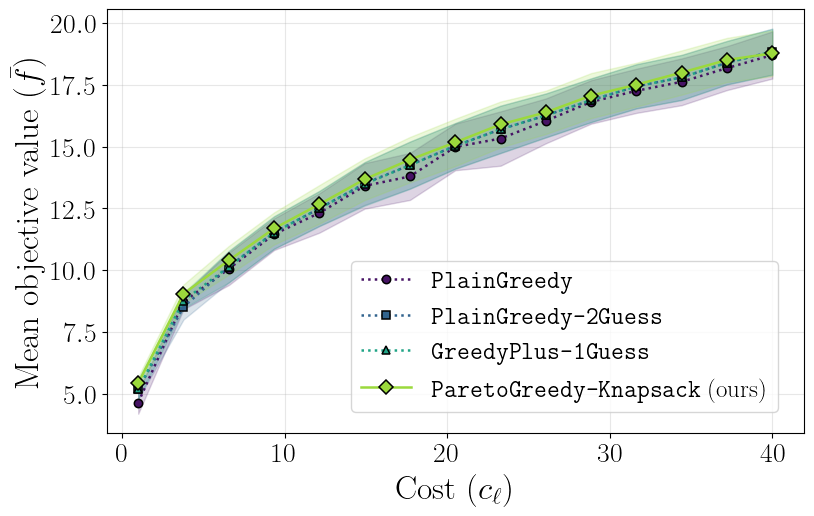

2026-01-25 23:37:34,737 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.157 ± 0.022
  - PlainGreedy-2Guess: 43.725 ± 11.980
  - GreedyPlus-1Guess: 19.911 ± 6.640
  - ParetoGreedy-Knapsack: 0.555 ± 0.083


In [5]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 5  # e.g., number of random samples
maxBudget = 40

findApproximateParetoSolutions(phoenix_simMatrix, phoenix_ids, phoenix_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-PHX")

### Yelp Vegas Experiments

In [6]:
#Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-01-25 23:37:34,780 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:37:34,782 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:37:34,788 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:37:34,806 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:37:34,869 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142


Starting processing 5 samples with sample size 50 and max budget 40
Processing sample 1/5


2026-01-25 23:37:35,073 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:37:35,570 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:37:36,505 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:37:38,156 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:37:40,700 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:37:44,450 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:37:49,434 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142
2026-01-25 23:37:55,961 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=34.42857142857143


  Running ParetoGreedy algorithms for sample 1


2026-01-25 23:38:24,050 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:38:24,053 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:38:24,063 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:38:24,089 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:38:24,171 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142


Completed sample 1
Processing sample 2/5


2026-01-25 23:38:24,344 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:38:24,737 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:38:25,452 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:38:26,749 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:38:28,670 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:38:31,536 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:38:35,507 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142
2026-01-25 23:38:40,644 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=34.42857142857143


  Running ParetoGreedy algorithms for sample 2


2026-01-25 23:39:03,584 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:39:03,586 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:39:03,590 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:39:03,598 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:39:03,612 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:39:03,666 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427


Completed sample 2
Processing sample 3/5


2026-01-25 23:39:03,836 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:39:04,284 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:39:05,314 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:39:07,178 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:39:09,802 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:39:13,501 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142
2026-01-25 23:39:18,404 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=34.42857142857143
2026-01-25 23:39:24,245 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=37.214285714285715


  Running ParetoGreedy algorithms for sample 3


2026-01-25 23:39:39,442 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:39:39,445 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:39:39,450 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:39:39,462 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:39:39,503 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:39:39,614 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427


Completed sample 3
Processing sample 4/5


2026-01-25 23:39:39,891 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715
2026-01-25 23:39:40,474 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:39:41,403 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:39:43,010 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:39:45,329 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:39:48,604 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142
2026-01-25 23:39:53,014 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=34.42857142857143
2026-01-25 23:39:58,505 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=37.214285714285715


  Running ParetoGreedy algorithms for sample 4


2026-01-25 23:40:13,348 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=1.0
2026-01-25 23:40:13,352 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=3.7857142857142856
2026-01-25 23:40:13,358 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=6.571428571428571
2026-01-25 23:40:13,367 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=9.357142857142858
2026-01-25 23:40:13,386 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=12.142857142857142
2026-01-25 23:40:13,435 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=14.928571428571427
2026-01-25 23:40:13,546 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=17.714285714285715


Completed sample 4
Processing sample 5/5


2026-01-25 23:40:13,793 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=20.5
2026-01-25 23:40:14,246 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=23.285714285714285
2026-01-25 23:40:15,077 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=26.07142857142857
2026-01-25 23:40:16,429 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=28.857142857142854
2026-01-25 23:40:18,509 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=31.642857142857142
2026-01-25 23:40:21,521 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=34.42857142857143
2026-01-25 23:40:25,684 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=37.214285714285715
2026-01-25 23:40:30,884 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:50, Budget=40.0
2026-01-25 23:

  Running ParetoGreedy algorithms for sample 5
Completed sample 5
All samples processed, computing statistics and plotting


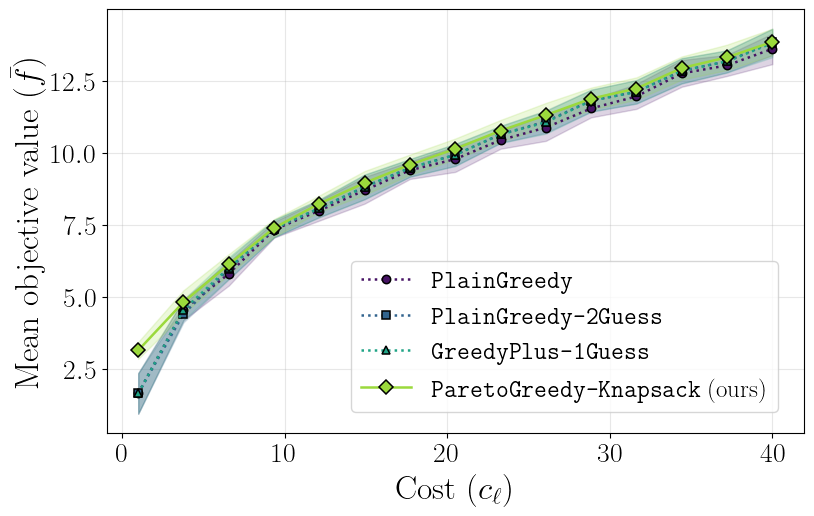

2026-01-25 23:40:37,898 |INFO: Runtime summary (mean ± std, seconds):
  - PlainGreedy: 0.131 ± 0.012
  - PlainGreedy-2Guess: 27.025 ± 6.374
  - GreedyPlus-1Guess: 8.929 ± 2.215
  - ParetoGreedy-Knapsack: 0.392 ± 0.061


In [7]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 50
numSamples = 5  # e.g., number of random samples
maxBudget = 40

findApproximateParetoSolutions(vegas_simMatrix, vegas_ids, vegas_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-LV")